In [1]:
PATH='/home/kirana/Documents/phd/experiment1_new/DNNREC_ML1M'
DATAPATH='/home/kirana/Documents/final_dissertation_final/experiments/datasets/ml-1m'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import os
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import pickle
from sklearn import metrics

In [3]:
[df,dftrain,dfvalid,idx_to_user,idx_to_item,item_to_idx,user_to_idx,results_concat]=\
    pickle.load(open(f'{DATAPATH}/df_side_cold_runother_cf.pkl','rb'))

In [4]:
dftrain.columns

Index(['index', 'age', 'flag_train', 'gender', 'genre', 'itemId', 'maxSeqNum',
       'month', 'month_acq', 'occupation',
       ...
       'f_tag_to', 'f_tag_trek', 'f_tag_wars', 'f_tag_weapon', 'f_tag_who',
       'f_tag_with', 'f_tag_world', 'f_tag_you', 'user_idx', 'item_idx'],
      dtype='object', length=392)

In [5]:
denseCols=dftrain.columns[dftrain.columns.str.startswith('f_t')].tolist()

In [6]:
denseCols

['f_title_1939',
 'f_title_1940',
 'f_title_1941',
 'f_title_1942',
 'f_title_1944',
 'f_title_1946',
 'f_title_1950',
 'f_title_1951',
 'f_title_1953',
 'f_title_1954',
 'f_title_1955',
 'f_title_1956',
 'f_title_1957',
 'f_title_1958',
 'f_title_1959',
 'f_title_1960',
 'f_title_1961',
 'f_title_1962',
 'f_title_1963',
 'f_title_1964',
 'f_title_1965',
 'f_title_1966',
 'f_title_1967',
 'f_title_1968',
 'f_title_1969',
 'f_title_1970',
 'f_title_1971',
 'f_title_1972',
 'f_title_1973',
 'f_title_1974',
 'f_title_1975',
 'f_title_1976',
 'f_title_1977',
 'f_title_1978',
 'f_title_1979',
 'f_title_1980',
 'f_title_1981',
 'f_title_1982',
 'f_title_1983',
 'f_title_1984',
 'f_title_1985',
 'f_title_1986',
 'f_title_1987',
 'f_title_1988',
 'f_title_1989',
 'f_title_1990',
 'f_title_1991',
 'f_title_1992',
 'f_title_1993',
 'f_title_1994',
 'f_title_1995',
 'f_title_1996',
 'f_title_1997',
 'f_title_1998',
 'f_title_1999',
 'f_title_2000',
 'f_title_about',
 'f_title_adventures',
 'f_tit

In [7]:
genre_to_idx={j:i+1 for i,j in enumerate(dftrain['genre'].unique())}
idx_to_genre={i+1:j for i,j in enumerate(dftrain['genre'].unique())}
dftrain['genre_idx']=[genre_to_idx.get(i) for i in dftrain['genre']]
dfvalid['genre_idx']=[genre_to_idx.get(i) for i in dfvalid['genre']]

In [8]:
occupation_to_idx={j:i+1 for i,j in enumerate(dftrain['occupation'].unique())}
idx_to_occupation={i+1:j for i,j in enumerate(dftrain['occupation'].unique())}
dftrain['occupation_idx']=[occupation_to_idx.get(i) for i in dftrain['occupation']]
dfvalid['occupation_idx']=[occupation_to_idx.get(i) for i in dfvalid['occupation']]

In [9]:
age_to_idx={j:i+1 for i,j in enumerate(dftrain['age'].unique())}
idx_to_age={i+1:j for i,j in enumerate(dftrain['age'].unique())}
dftrain['age_idx']=[age_to_idx.get(i) for i in dftrain['age']]
dfvalid['age_idx']=[age_to_idx.get(i) for i in dfvalid['age']]

In [12]:
gender_to_idx={j:i+1 for i,j in enumerate(dftrain['gender'].unique())}
idx_to_gender={i+1:j for i,j in enumerate(dftrain['gender'].unique())}
dftrain['gender_idx']=[gender_to_idx.get(i) for i in dftrain['gender']]
dfvalid['gender_idx']=[gender_to_idx.get(i) for i in dfvalid['gender']]

In [13]:
catCols=['genre_idx','occupation_idx','age_idx','gender_idx']
catCols=['occupation_idx','age_idx','gender_idx']

### Dataset and DataLoader

In [14]:
class cfdata (torch.utils.data.dataset.Dataset):
    def __init__(self,dfX,dfY,denseCols,catCols):
        self.dfX,self.dfY=dfX,dfY
        self.denseCols=denseCols
        self.catCols=catCols
        
    def __len__ (self):
        return self.dfX.shape[0]
    
    def __getitem__ (self, idx):
        return torch.FloatTensor(self.dfX.iloc[idx].values),torch.FloatTensor([self.dfY.values[idx]])

In [15]:
dstrain=cfdata(dftrain[['user_idx','item_idx']+denseCols+catCols],dftrain['rating'],denseCols,catCols)
dsvalid=cfdata(dfvalid[['user_idx','item_idx']+denseCols+catCols],dfvalid['rating'],denseCols,catCols)

In [16]:
dftrain.shape

(895738, 396)

In [17]:
bs=128

In [18]:
dltrain=DataLoader(dstrain,bs,True)

In [19]:
dlvalid=DataLoader(dsvalid,bs,False)

In [20]:
dftrain['genre'].nunique()

301

In [21]:
[(col, dftrain[col].nunique()) for col in catCols]

[('occupation_idx', 21), ('age_idx', 7), ('gender_idx', 2)]

In [22]:
{col: min(50,dftrain[col].nunique()//100) for col in catCols}

{'occupation_idx': 0, 'age_idx': 0, 'gender_idx': 0}

In [23]:
emb_szs=[(dftrain[col].nunique(),min(50,dftrain[col].nunique()//2)) for col in catCols]

In [24]:
emb_szs

[(21, 10), (7, 3), (2, 1)]

## Model Architecture

In [25]:
n_users=len(user_to_idx)
n_items=len(item_to_idx)
n_emb_user=50
n_emb_item=50
min_rating=min(dftrain['rating'])
max_rating=max(dftrain['rating'])
dropout_e=0.05
    # embedding, dense, cat, final
hidden=[25,1,5,10]
dropouts=[0.2,0.3,0.2,0]

In [26]:
def hidden_layer(x,y,dropout,activation=nn.Sigmoid()):
    return nn.Sequential(
        nn.Linear(x, y),
        activation,
        nn.Dropout(p=dropout)
        )   

In [27]:
#[mtx_user_emb,mtx_item_emb,user_bias_emb,item_bias_emb]=pickle.load(open(f'{DATAPATH}/wts_embs','rb'))
pretrain_wts=pickle.load(open(f'{DATAPATH}/wts_embs_50','rb'))
#pretrain_wts=None

In [31]:
class cf(nn.Module):    
    def __init__(self,n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,autoenc_cols,pretrain_wts,\
                 catCols, emb_szs,dropout_e=0.01,hidden=[15,5],dropouts=[0.2,0.2],error_type="mse"):
        super().__init__()
        self.n_users,self.n_emb_user,self.n_emb_item,self.n_items,self.min_rating,self.max_rating=\
                    n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating
        self.dropout_e,self.hidden,self.dropouts=dropout_e,hidden,dropouts
        self.autoenc_cols,self.len_dense_cols=autoenc_cols,len(autoenc_cols)
        self.catCols,self.emb_szs=catCols,emb_szs
        self.len_cat_cols=len(self.catCols)
        self.n_cat_emb=sum([x[1] for x in emb_szs])
        
        
        self.create_architecture()
        self.init_parameters()
        
        if pretrain_wts is not None:
            self.emb_user.weight.data=torch.FloatTensor(pretrain_wts[0])
            self.emb_item.weight.data=torch.FloatTensor(pretrain_wts[1])
            self.ub.weight.data=torch.FloatTensor(pretrain_wts[2])
            self.ib.weight.data=torch.FloatTensor(pretrain_wts[3])

        if error_type!="mse":
            self.criterion=nn.L1Loss()
        else:
            self.criterion=nn.MSELoss()
        
    def create_architecture(self):
        self.emb_user=nn.Embedding(self.n_users+1,self.n_emb_user)
        self.emb_item=nn.Embedding(self.n_items+1,self.n_emb_item)
        self.ub=nn.Embedding(self.n_users+1,1)
        self.ib=nn.Embedding(self.n_items+1,1)
        self.embs_cat=nn.ModuleList([nn.Embedding(x+1,y) for x,y in self.emb_szs])
        
        self.emb_dropout=nn.Dropout(self.dropout_e)

        
        self.lin1= nn.Sequential(nn.Linear(self.n_emb_user+self.n_emb_item,self.hidden[0]),
                    nn.ReLU(),
                    nn.Dropout(p=dropouts[0]) )
        self.lin_bias=nn.Linear(3,1)
       

        
        self.lin_cat= nn.Sequential (nn.Linear(self.n_cat_emb,self.hidden[2]),
                                nn.ReLU(),
                                nn.Dropout(p=dropouts[2]))
        self.lin3= nn.Sequential (nn.Linear(self.hidden[0]+1+self.hidden[2],self.hidden[3]),
                    nn.ReLU(),
                    nn.Dropout(p=dropouts[3]))
        self.lin4=nn.Linear(self.hidden[3],1)
        self.sigmoid=nn.Sigmoid()
        
        
    def init_parameters(self):
        nn.init.kaiming_normal_(self.emb_user.weight.data)
        nn.init.kaiming_normal_(self.emb_item.weight.data)
        nn.init.zeros_(self.ub.weight.data)
        nn.init.zeros_(self.ib.weight.data)
        nn.init.kaiming_normal_(self.lin1[0].weight.data)
        #nn.init.kaiming_normal_(self.lin2[0].weight.data)
        nn.init.kaiming_normal_(self.lin3[0].weight.data)
        #nn.init.kaiming_normal_(lin)
       
    def forward (self,Xb,Yb):
        users=Xb[:,0].long()
        items=Xb[:,1].long()
        users=self.emb_dropout(self.emb_user(users))
        items=self.emb_dropout(self.emb_item(items))
        users_bias=self.emb_dropout(self.ub(Xb[:,0].long()))
        items_bias=self.emb_dropout(self.ib(Xb[:,1].long()))
        embed=torch.cat([users,items],1)
        out1=self.lin1(embed)
        bias=torch.cat([users_bias,items_bias,users_bias+items_bias],1)
        biased=self.lin_bias(bias)
           
        
    
                  
        cats=Xb[:,(2+self.len_dense_cols):].long()
        embed_cat=[self.emb_dropout(self.embs_cat[i](cats[:,i]) ) for i in range(len(self.emb_szs))]
        embedded_cat = torch.cat([x for x in embed_cat],1)
        out_cat=self.lin_cat(embedded_cat)
        
        out3=torch.cat([out1,biased,out_cat],1)
        
        out4=self.lin3(out3)
        
        out5=self.lin4(out4)
        
        out=self.sigmoid(out5)
        
        preds=out*(self.max_rating-self.min_rating)+self.min_rating
        #preds=torch.clamp(out,self.min_rating,self.max_rating)
        #preds=preds.view(-1)
        loss=self.criterion(preds,Yb)
        return preds,loss

In [32]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,denseCols,pretrain_wts,catCols,emb_szs,dropout_e,hidden,dropouts,error_type="mse")

In [33]:
cfobj

cf(
  (emb_user): Embedding(6041, 50)
  (emb_item): Embedding(3707, 50)
  (ub): Embedding(6041, 1)
  (ib): Embedding(3707, 1)
  (embs_cat): ModuleList(
    (0): Embedding(22, 10)
    (1): Embedding(8, 3)
    (2): Embedding(3, 1)
  )
  (emb_dropout): Dropout(p=0.05)
  (lin1): Sequential(
    (0): Linear(in_features=100, out_features=25, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2)
  )
  (lin_bias): Linear(in_features=3, out_features=1, bias=True)
  (lin_cat): Sequential(
    (0): Linear(in_features=14, out_features=5, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2)
  )
  (lin3): Sequential(
    (0): Linear(in_features=31, out_features=10, bias=True)
    (1): ReLU()
    (2): Dropout(p=0)
  )
  (lin4): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [34]:
for Xb, Yb in dltrain:
    break

In [35]:
Xb.shape, Yb.shape

(torch.Size([128, 355]), torch.Size([128, 1]))

In [36]:
Xb.dtype

torch.float32

In [37]:
cfobj.forward(Xb,Yb)

(tensor([[3.4500],
         [3.0853],
         [3.1095],
         [3.3422],
         [3.2270],
         [3.1620],
         [3.4808],
         [3.3716],
         [3.4227],
         [3.3404],
         [2.9000],
         [3.5517],
         [3.3188],
         [3.4406],
         [3.2285],
         [3.3043],
         [2.8403],
         [3.2660],
         [3.0302],
         [3.2841],
         [2.9287],
         [2.9917],
         [3.1248],
         [3.4982],
         [2.9836],
         [3.3583],
         [3.0463],
         [3.0728],
         [3.7746],
         [3.5697],
         [2.9725],
         [3.1097],
         [3.2421],
         [3.4069],
         [3.2384],
         [3.4442],
         [3.0832],
         [3.4934],
         [3.4134],
         [3.1642],
         [3.4909],
         [3.1376],
         [3.4249],
         [3.6910],
         [3.4115],
         [3.2152],
         [3.2377],
         [3.1809],
         [3.4882],
         [3.8420],
         [3.4076],
         [3.2297],
         [3.

## Learner

In [38]:
class Learner():
    def __init__(self,model,optimizer,metric_fn,device,bptt=12,print_every=5,clip_val=None,\
                 cycle_mult=0,lr_decay=0.7,wd_mult=1.1,start_lr=2e-2, end_lr=5e-4,error_type="mse"):
        self.model,self.optimizer,self.metric_fn,self.device,self.print_every,self.bptt,self.losses,self.clip_val=\
            model,optimizer,metric_fn,device,print_every,bptt,[],clip_val
        self.n_epochs=1
        self.cycle_mult,self.lr_decay=cycle_mult,lr_decay
        self.wd_mult=wd_mult
        for param_group in self.optimizer.param_groups:
            self.start_lr=param_group['lr']
            self.start_wd=param_group['weight_decay']
        self.wd=self.start_wd
        self.lr=self.start_lr
        self.end_lr=end_lr
        self.n_epoch=0
        self.lrs=[1e-2,5e-3,1e-4,5e-4]
        self.preds,self.preds_valid,self.trainY,self.actual=[],[],[],[]
        self.ratio=self.end_lr/self.start_lr
        self.num_steps=self.cycle_mult
        self.reset_cycle=self.cycle_mult
        self.error_type=error_type
        self.scores=[]
        self.generate_scores=False
        
    def fit (self,Xb,Yb,mode_train=True):
        if mode_train:
            self.model.train()
        else:
            self.model.eval()
        
        #import pdb
        #pdb.set_trace()
        preds,loss=self.model(Xb,Yb)

     
        if mode_train:
            if 1==0:
                lr =self.lrs[torch.randint(0,4,(1,))]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        myloss=loss.item()
    
        
        with torch.no_grad():
            if self.error_type == "mse":
                acc=nn.L1Loss() (preds,Yb)
                myrmse=np.sqrt(myloss)
            else:
                acc=nn.MSELoss() (preds,Yb)
                myrmse=np.sqrt(acc.item())
            acc=acc.item()
                 
        if mode_train==False:
            if self.generate_scores:
                self.scores.append(preds.detach().cpu().numpy().flatten())
        del preds
        del loss
        
        if self.clip_val is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_val)
        
        return myloss, acc, myrmse
    
    def lr_find (self,start_lr,end_lr,iterator,n_batch):
        losses,lrs=[],[]
        ratio=end_lr/start_lr
        num_steps=n_batch
        lr=start_lr
        for i in range(num_steps):            
            lr=lr*(end_lr/start_lr)**(1/num_steps)
            lrs.append(lr)
        self.lrs=lrs
        self.run_epoch(iterator,mode_train=True,lrs=lrs)
    
    def run_epoch(self,iterator,mode_train,lrs=None):
        epoch_loss,epoch_acc,i,k=0,0,0,0
        epoch_rmse=0

        for Xb,Yb in iterator:
            Xb=Xb.to(self.device)
            Yb=Yb.to(self.device)
            
            if lrs is not None:
                lr=lrs[k]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr 
            
            loss,acc,myrmse=self.fit(Xb,Yb,mode_train)
            
            if lrs is not None:
                self.losses.append(loss)

            epoch_loss+=loss
            epoch_acc+=acc
            epoch_rmse+=myrmse
            
            k=k+1
            if k%self.print_every == 0:
                if k:
                    print (f'Batch:{k} {epoch_loss/(k)}  ')  
                    torch.cuda.empty_cache()

        epoch_loss=epoch_loss/len(iterator)
        epoch_acc=epoch_acc/len(iterator)
        epoch_rmse=epoch_rmse/len(iterator)
            
        return epoch_loss,epoch_acc,epoch_rmse
    
    def plot_lrs(self, n_roll=1,ylim=None,xlim=None,ignore=0):
        import seaborn as sns
        ax=sns.lineplot(x=self.lrs[ignore:],y=pd.Series(self.losses[ignore:]).rolling(n_roll).mean())
        ax.set_xscale('log')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate')
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)

     
    def run_epochs(self,dltrain,dlvalid,n_epochs=1):              
        for epoch in range(n_epochs):                
            loss,acc,rmse=self.run_epoch(dltrain,True)

            lossv,accv,rmsev=self.run_epoch(dlvalid,mode_train=False)
           
            if self.error_type=="mse":
                loss_mse=loss
                loss_rmse=rmse
                loss_mae=acc
                lossv_mse=lossv
                lossv_rmse=rmsev
                lossv_mae=accv
                
            else:
                loss_mse=acc
                loss_rmse=rmse
                loss_mae=loss
                lossv_mse=accv
                lossv_rmse=rmsev
                lossv_mae=lossv
            
            print (f'Epoch:{epoch} Learning rate {self.lr} Weight Decay {self.wd} Train Loss:{loss} \
                Valid Loss:{lossv} Train RMSE:{loss_rmse} Valid RMSE:{lossv_rmse} Train MSE:{loss_mse} Valid MSE:{lossv_mse} \
                Train MAE:{loss_mae} Valid MAE:{lossv_mae}')

              
         
     
            if self.cycle_mult:
                if self.n_epoch==self.reset_cycle:
                    self.lr=self.start_lr
                    #self.wd=self.start_wd
                    self.reset_cycle*=self.cycle_mult
                    #reset_cycle=self.n_epoch+reset_cycle
                    self.n_epoch=0
                    self.ratio=self.end_lr/self.start_lr
                    self.num_steps=self.reset_cycle
                else:
                    #self.lr*=(self.lr_decay**self.n_epoch)  
                    #if self.n_epoch>1:
                    self.wd*=self.wd_mult
                    self.lr=self.lr*(self.end_lr/self.start_lr)**(1/self.num_steps)
                    self.n_epoch+=1
        

                
            for param_group in self.optimizer.param_groups:
                param_group['lr']=self.lr
                param_group['weight_decay']=self.wd
          
     

In [40]:
device='cuda:1'

In [41]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,denseCols,pretrain_wts,catCols,emb_szs,dropout_e,hidden,dropouts,error_type="mse")

In [42]:
cfobj=cfobj.to(device)

In [43]:
cfobj

cf(
  (emb_user): Embedding(6041, 50)
  (emb_item): Embedding(3707, 50)
  (ub): Embedding(6041, 1)
  (ib): Embedding(3707, 1)
  (embs_cat): ModuleList(
    (0): Embedding(22, 10)
    (1): Embedding(8, 3)
    (2): Embedding(3, 1)
  )
  (emb_dropout): Dropout(p=0.05)
  (lin1): Sequential(
    (0): Linear(in_features=100, out_features=25, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2)
  )
  (lin_bias): Linear(in_features=3, out_features=1, bias=True)
  (lin_cat): Sequential(
    (0): Linear(in_features=14, out_features=5, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2)
  )
  (lin3): Sequential(
    (0): Linear(in_features=31, out_features=10, bias=True)
    (1): ReLU()
    (2): Dropout(p=0)
  )
  (lin4): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [44]:
wd=1e-5
optimizer=torch.optim.Adam(cfobj.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,14000,0.25,cycle_mult=0)

In [45]:
dltrain.batch_size, len(dltrain)

(128, 6998)

In [46]:
learner.lr_find(1e-5,1e-1,dltrain,len(dltrain))

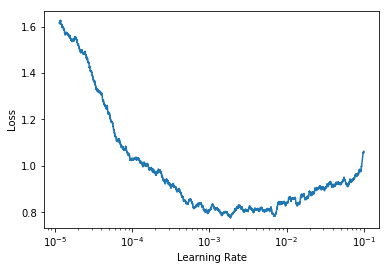

In [47]:
learner.plot_lrs(100)

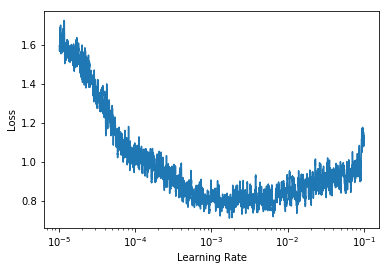

In [48]:
learner.plot_lrs(10)

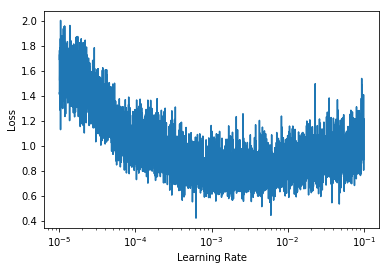

In [49]:
learner.plot_lrs(1)

In [50]:
del cfobj
torch.cuda.empty_cache()

In [51]:
pretrain_wts=pickle.load(open(f'{DATAPATH}/wts_embs_50','rb'))
#pretrain_wts=None

In [52]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,denseCols,pretrain_wts,catCols,emb_szs,dropout_e,hidden,dropouts,error_type="mse")
cfobj=cfobj.to(device)

In [53]:
if 1==1:
    cfobj.emb_user.weight.requires_grad=False
    cfobj.emb_item.weight.requires_grad=False
    cfobj.ib.weight.requires_grad=False
    cfobj.ub.weight.requires_grad=False

In [54]:
print (wd)
wd=1e-5
optimizer=torch.optim.Adam(cfobj.parameters(),lr=1e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,12000,0.25,cycle_mult=2,start_lr=6e-4,end_lr=1e-4,wd_mult=1.05)

1e-05


In [55]:
learner.run_epochs(dltrain,dlvalid,15)

Epoch:0 Learning rate 0.001 Weight Decay 1e-05 Train Loss:0.7723588414083518                 Valid Loss:0.8072297277984596 Train RMSE:0.8760632804610784 Valid RMSE:0.889150492346807 Train MSE:0.7723588414083518 Valid MSE:0.8072297277984596                 Train MAE:0.6960302891050553 Valid MAE:0.7094078593621785
Epoch:1 Learning rate 0.00031622776601683794 Weight Decay 1.0500000000000001e-05 Train Loss:0.729338858337292                 Valid Loss:0.802745805011385 Train RMSE:0.852037330026045 Valid RMSE:0.8869234029082298 Train MSE:0.729338858337292 Valid MSE:0.802745805011385                 Train MAE:0.6755587931240106 Valid MAE:0.7094912281307771
Epoch:2 Learning rate 0.0001 Weight Decay 1.1025000000000002e-05 Train Loss:0.7251667134989735                 Valid Loss:0.8030155917203265 Train RMSE:0.8495452389661079 Valid RMSE:0.8869918024663181 Train MSE:0.7251667134989735 Valid MSE:0.8030155917203265                 Train MAE:0.6734501669733277 Valid MAE:0.7094484586610642
Epoch:3 L

In [56]:
if 1==1:
    cfobj.emb_user.weight.requires_grad=True
    cfobj.emb_item.weight.requires_grad=True
    cfobj.ib.weight.requires_grad=True
    cfobj.ub.weight.requires_grad=True

In [57]:
if 1==1:
    for param_group in optimizer.param_groups:
        param_group['lr']=3e-4
    learner=Learner(cfobj,optimizer,None,device,0,12000,0.25,cycle_mult=2,start_lr=3e-4,end_lr=7e-5,wd_mult=1.05)
    learner.run_epochs(dltrain,dlvalid,7)

Epoch:0 Learning rate 0.0003 Weight Decay 1.8856491423232372e-05 Train Loss:0.7218883736120288                 Valid Loss:0.7946537662675944 Train RMSE:0.8476968167065609 Valid RMSE:0.8822822697180195 Train MSE:0.7218883736120288 Valid MSE:0.7946537662675944                 Train MAE:0.6713438447832073 Valid MAE:0.7065213573241613
Epoch:1 Learning rate 0.00014491376746189437 Weight Decay 1.9799315994393993e-05 Train Loss:0.7028863380196504                 Valid Loss:0.7905848874018563 Train RMSE:0.8364133341075091 Valid RMSE:0.8801002473684062 Train MSE:0.7028863380196504 Valid MSE:0.7905848874018563                 Train MAE:0.6617342639255606 Valid MAE:0.70390401461425
Epoch:2 Learning rate 7e-05 Weight Decay 2.0789281794113692e-05 Train Loss:0.6938366594485604                 Valid Loss:0.7900981731630743 Train RMSE:0.8309251168777697 Valid RMSE:0.8797649390390212 Train MSE:0.6938366594485604 Valid MSE:0.7900981731630743                 Train MAE:0.6569332135221079 Valid MAE:0.70403

In [58]:
learner.generate_scores=True

In [59]:
learner.run_epoch(dlvalid,False)

(0.7897164907712247, 0.7041511572851837, 0.8795253934299572)

In [60]:
dfvalid['pred_dnnrec']=np.concatenate(learner.scores)

In [61]:
np.sqrt(metrics.mean_squared_error(dfvalid['rating'],dfvalid['pred_dnnrec']))

0.888702840126919

In [62]:
def score_by_group (dfvalid,predVar,groupVar='cold_start_group',method='global_avg'):
    scores=[]
    mae_scores=[]
    rmse_scores=[]
    r2_scores=[]
    groups=dfvalid[groupVar].value_counts().index.tolist()
    for group in groups:
        df=dfvalid.loc[dfvalid[groupVar]==group]
        actual=df['rating']
        score=metrics.mean_squared_error(df['rating'],df[predVar])
        rmse_score=np.sqrt(metrics.mean_squared_error(df['rating'],df[predVar]))
        mae_score=metrics.mean_absolute_error(df['rating'],df[predVar])
        r2_score=metrics.r2_score(df['rating'],df[predVar])
        scores.append(score)
        mae_scores.append(mae_score)
        rmse_scores.append(rmse_score)
        r2_scores.append(r2_score)
    return pd.DataFrame({'method':method, 'mse':scores, 'rmse':rmse_scores, 'mae':mae_scores, 'r2_score':r2_scores, 'Cold Start Group':groups})

In [63]:
result_dnnrec=pd.concat([score_by_group(dfvalid,'pred_dnnrec','cold_start_group','dnnrec'),score_by_group(dfvalid,'pred_dnnrec','cold_start_bucket','dnnrec'),\
score_by_group(dfvalid,'pred_dnnrec','flag_train','dnnrec')],axis=0)
result_dnnrec

,method,mse,rmse,mae,r2_score,Cold Start Group
0,dnnrec,0.763591,0.873837,0.690416,0.418675,No-cold-start
1,dnnrec,1.059578,1.029358,0.845621,0.113798,User-Cold-Start
2,dnnrec,0.768945,0.876895,0.716695,0.077266,Item-Cold_start
3,dnnrec,1.877093,1.370070,1.002753,-0.877093,User-Item-cold-start
0,dnnrec,0.763591,0.873837,0.690416,0.418675,0
1,dnnrec,1.059002,1.029078,0.845321,0.114367,1
0,dnnrec,0.789793,0.888703,0.704156,0.395735,0


In [73]:
print (pd.crosstab(dfvalid['cold_start_user'],dfvalid['cold_start_item']))
print (pd.crosstab(dfvalid['cold_start_user'],dfvalid['cold_start_item'])/dfvalid.shape[0])   

cold_start_item  False  True 
cold_start_user              
False            95205     24
True              9240      2
cold_start_item     False     True 
cold_start_user                    
False            0.911306  0.000230
True             0.088446  0.000019


In [57]:
result_dnnrec=pd.concat([score_by_group(dfvalid,'pred_dnnrec','cold_start_group','dnnrec'),score_by_group(dfvalid,'pred_dnnrec','cold_start_bucket','dnnrec'),\
score_by_group(dfvalid,'pred_dnnrec','flag_train','dnnrec')],axis=0)
result_dnnrec

,method,mse,rmse,mae,r2_score,Cold Start Group
0,dnnrec,0.799263,0.894015,0.701140,0.391519,No-cold-start
1,dnnrec,0.973265,0.986542,0.797614,0.185988,User-Cold-Start
2,dnnrec,0.758376,0.870848,0.715059,0.089948,Item-Cold_start
3,dnnrec,1.749977,1.322867,1.031915,-0.749977,User-Item-cold-start
0,dnnrec,0.799263,0.894015,0.701140,0.391519,0
1,dnnrec,0.972876,0.986345,0.797451,0.186393,1
0,dnnrec,0.814661,0.902586,0.709682,0.376708,0


In [68]:
torch.save(cfobj,f=f'{DATAPATH}/inter/cfobj_tl_0.8')
torch.save(learner,f=f'{DATAPATH}/inter/cfobj_tl_learner_0.8')
torch.save(optimizer,f=f'{DATAPATH}/inter/cfobj_tl_optimizer_0.8')
torch.save(cfobj.state_dict(),f'{DATAPATH}/inter/cfjobj_tl_state_dict_0.8')
torch.save(optimizer.state_dict(),f'{DATAPATH}/inter/optimizer_tl_state_dict_0.8')

/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type cf. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [69]:
results_concat.shape

(66, 6)

In [70]:
results_concat=pd.concat([results_concat,result_dnnrec],axis=0)

In [71]:
pickle.dump([df,dftrain,dfvalid,idx_to_user,idx_to_item,item_to_idx,user_to_idx,results_concat],open(f'{DATAPATH}/df_side_cold_runother_dnnrec.pkl','wb'))